# Visualize othello board with highlighted background

Input to the model: "int", doesn't contain middle pieces
For plotting and correct conversion to board visualization: "string", does mind middle pieces 

## Setup

In [1]:
import os
import pickle

import torch as t
from huggingface_hub import hf_hub_download
import einops

from circuits.dictionary_learning.dictionary import AutoEncoder, AutoEncoderNew, GatedAutoEncoder, IdentityDict
from circuits.utils import (
    othello_hf_dataset_to_generator,
    get_model,
    get_submodule,
)

from feature_viz_othello_utils import (
    get_acts_IEs_VN,
    plot_lenses_encoder,
    plot_lenses_decoder,
    plot_mean_metrics,
    plot_top_k_games,
    BoardPlayer,
)
from circuits.othello_engine_utils import (
    to_board_label
)

import circuits.utils as utils
import circuits.analysis as analysis

device = 'cuda:0'
# repo_dir = '/home/can/chess-gpt-circuits'
repo_dir = '/share/u/can/chess-gpt-circuits'
# repo_dir = "/home/adam/chess-gpt-circuits"

/share/u/can/miniconda3/envs/mats-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load model and data
context_length = 59
activation_dim = 512  # output dimension of the layer
model_name = "Baidicoot/Othello-GPT-Transformer-Lens"
dataset_name = "taufeeque/othellogpt"

model = get_model(model_name, device)


data = othello_hf_dataset_to_generator(
    dataset_name, context_length=context_length, split="train", streaming=True
)

Loaded pretrained model Baidicoot/Othello-GPT-Transformer-Lens into HookedTransformer
Moving model to device:  cuda:0


In [3]:
layer = 0
# node_type = "sae_feature"
node_type = "mlp_neuron"


if node_type == "sae_feature":
    ae_group_name = 'all_layers_othello_p_anneal_0530_with_lines'
    ae_type = 'p_anneal'
    trainer_id = 0
    ae_path = f'{repo_dir}/autoencoders/{ae_group_name}/layer_{layer}/trainer{trainer_id}'
elif node_type == "mlp_neuron":
    ae_group_name = 'othello_mlp_acts_identity_aes_lines' # with_lines
    ae_type = 'identity'
    ae_path = f'{repo_dir}/autoencoders/{ae_group_name}/layer_{layer}'
else:
    raise ValueError('Invalid node_type')

# download data from huggingface if needed
if not os.path.exists(f'{repo_dir}/autoencoders/{ae_group_name}'):
    hf_hub_download(repo_id='adamkarvonen/othello_saes', filename=f'{ae_group_name}.zip', local_dir=f'{repo_dir}/autoencoders')
    # unzip the data
    os.system(f'unzip {repo_dir}/autoencoders/{ae_group_name}.zip -d {repo_dir}/autoencoders')

# Initialize the autoencoder
if ae_type == 'standard' or ae_type == 'p_anneal':
    ae = AutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
elif ae_type == 'gated' or ae_type == 'gated_anneal':
    ae = GatedAutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
elif ae_type == 'standard_new':
    ae = AutoEncoderNew.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
elif ae_type == 'identity':
    ae = IdentityDict()
else:
    raise ValueError('Invalid ae_type')

In [4]:
# M = Activation dimension
# S = Sequence length
# B = Batch size, ie games per batch
# L = Number of batches
# N = L * B = Total number of games

B = 32 # B
L = 1 # L

games_batch_LBS = [[next(data) for _ in range(B)] for _ in range(L)]
games_batch_LBS = t.tensor(games_batch_LBS, device=device)
print(f'game_batch shape: {games_batch_LBS.shape}')

game_batch shape: torch.Size([1, 32, 59])


In [5]:
# load feature analysis results
def to_device(d, device=device):
    if isinstance(d, t.Tensor):
        return d.to(device)
    if isinstance(d, dict):
        return {k: to_device(v, device) for k, v in d.items()}


with open (os.path.join(ae_path, 'indexing_None_n_inputs_1000_results.pkl'), 'rb') as f:
    results = pickle.load(f)

results = utils.to_device(results, device)

print(results.keys())

feature_labels, misc_stats = analysis.analyze_results_dict(results, "", device, save_results=False, verbose=False, print_results=False, significance_threshold=100)
print(feature_labels.keys())


with open (os.path.join(ae_path, 'n_inputs_1000_evals.pkl'), 'rb') as f:
    eval_results = pickle.load(f)
print(eval_results.keys())
print(f"L0: {eval_results['eval_results']['l0']}")

dict_keys(['on_count', 'off_count', 'alive_features', 'games_batch_to_state_stack_mine_yours_BLRRC', 'games_batch_to_state_stack_mine_yours_blank_mask_BLRRC', 'games_batch_to_valid_moves_BLRRC', 'games_batch_to_state_stack_length_lines_mine_BLRCC', 'hyperparameters', 'trainer_class', 'sae_class'])
dict_keys(['thresholds', 'alive_features', 'indexing_function', 'games_batch_to_state_stack_mine_yours_BLRRC', 'games_batch_to_state_stack_mine_yours_blank_mask_BLRRC', 'games_batch_to_valid_moves_BLRRC'])
dict_keys(['hyperparameters', 'eval_results'])
L0: 2025.199951171875


# Here's the interactive part

In [6]:
def find_alive_feature_idx(desired_feat_idx: int, feature_labels: dict) -> int:
    for idx, feat_idx in enumerate(feature_labels['alive_features']):
        if feat_idx == desired_feat_idx:
            print(f"Found feature index {desired_feat_idx} at index {idx}")
            return idx
    raise ValueError(f"Feature index {desired_feat_idx} not found in alive features")

# alive_idx = find_alive_feature_idx(3098, feature_labels)
alive_idx = 0
show_indirect_effects = True
# node_type = 'sae_feature'
node_type = 'mlp_neuron' # ['sae_feature', 'mlp_neuron']

In [7]:
resid_submodule = model.blocks[layer].hook_resid_post
mlp_submodule = model.blocks[layer].mlp.hook_post
mlp_post_submodules = [model.blocks[l].mlp.hook_post for l in range(model.cfg.n_layers)]

if node_type == 'sae_feature':
    node_idx = int(feature_labels['alive_features'][alive_idx])
    submodule = resid_submodule
    chosen_ae = ae
elif node_type == 'mlp_neuron':
    node_idx = alive_idx
    submodule = mlp_submodule
    chosen_ae = None
else:
    raise ValueError('Invalid node_type')

## Weight space
Cosine sim of feature decoder vector with 
- token_embed
- unembed

In [8]:
import importlib
import feature_viz_othello_utils
importlib.reload(feature_viz_othello_utils) 


<module 'feature_viz_othello_utils' from '/share/u/can/OthelloUnderstanding/feature_viz_othello_utils.py'>

## Activation space

1. Feature act per input_token
2. IE input_token --> feature
3. IE feature --> logit

- mean over N games
- topK over N games

In [9]:
node_idx = 0

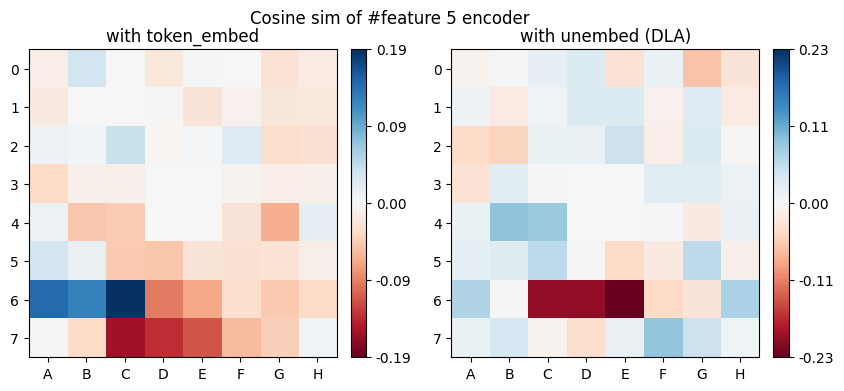

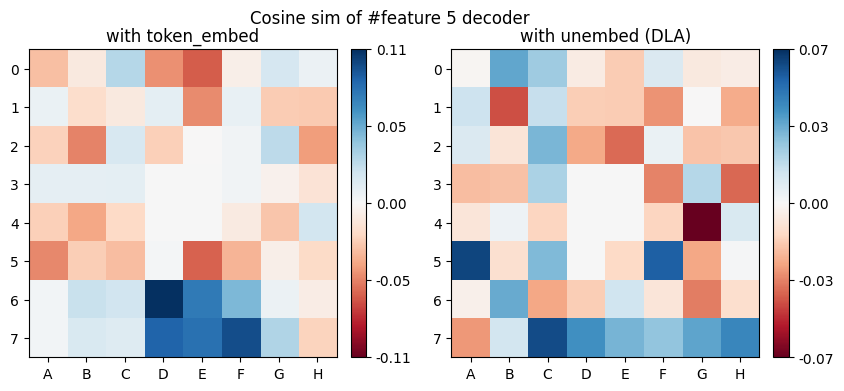

Games batch: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


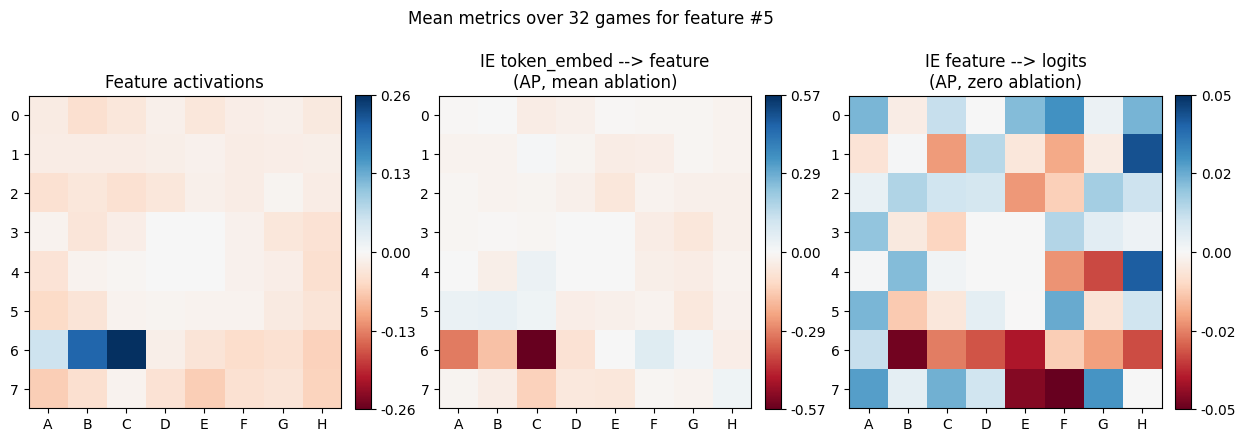

In [15]:

feature_viz_othello_utils.plot_lenses_encoder(model, ae, node_idx, device, node_type, layer=layer)
feature_viz_othello_utils.plot_lenses_decoder(model, ae, node_idx, device, node_type, layer=layer)

t.cuda.empty_cache()
t.set_grad_enabled(False)

if show_indirect_effects:
    t.set_grad_enabled(True)

feature_acts_NS, acts_per_tokenembed_VN, ie_feature_to_logits_VN, ie_tokenembed_to_features_VN = get_acts_IEs_VN(
    model, chosen_ae, games_batch_LBS, submodule, feat_idx=node_idx, compute_ie=show_indirect_effects, device=device
)

# print(f'feat_idx: {node_idx}')
# print(f'games_batch shape: {games_batch_LBS.shape}')
# print(f'feature_acts shape: {feature_acts_NS.shape}')

plot_mean_metrics(
    acts_per_tokenembed_VN, ie_tokenembed_to_features_VN, ie_feature_to_logits_VN, 
    node_idx, n_games=B*L, device=device, with_ie=show_indirect_effects
    )

node_idx += 1

In [14]:
# Choose metric to retrieve top k games
k = 10
sort_metric = 'activation' # ['activation', 'ie_embed','ie_logit']

games_batch_NS = games_batch_LBS.view(-1, context_length)

plot_top_k_games(
    node_idx,
    games_batch_NS,
    feature_acts_NS,
    acts_per_tokenembed_VN,
    ie_tokenembed_to_features_VN,
    ie_feature_to_logits_VN,
    sort_metric=sort_metric,
    k=k,
    with_ie=show_indirect_effects,
    device=device,
)

Top 1 activation game:


AttributeError: module 'circuits.othello_utils' has no attribute 'to_board_label'

## Board reconstruction: lookup table for high precision classifiers

In [18]:
# board_state_function = 'games_batch_to_state_stack_mine_yours_BLRRC'
board_state_function = 'games_batch_to_state_stack_mine_yours_blank_mask_BLRRC'
# board_state_function = 'games_batch_to_valid_moves_BLRRC'

# # There's 11 thresholds in the lookup table. If 0, the lookup table is constructed from every activation
# # If 1, it's constructed from all activations above 10% of that feature's max activation. If 2, 20% etc.
# # 1 is a reasonable default
# threshold_idx = 5

# demo_idx = None

# squares_classified_counts = []
# for alive_feature_index in range(len(feature_labels['alive_features'])):
#     num_classified_squares = feature_labels[board_state_function][threshold_idx][alive_feature_index].sum()
#     if num_classified_squares > 0:
#         print(f'Feature {alive_feature_index} has {num_classified_squares} classified squares')
#         squares_classified_counts.append(num_classified_squares.item())

#         demo_idx = alive_feature_index

# if demo_idx is None:
#     raise ValueError('No features have any classified squares')

In [19]:
node_idx = alive_idx
node_idx = 60
print(f'feat_idx: {node_idx}')

feat_idx: 60


In [ ]:
threshold_idx = 5
print("Board states that the feature classifies according to Adam's measurements:")
print((feature_labels[board_state_function][threshold_idx][node_idx] == 1).nonzero())
print("Number of such board states:")
print((feature_labels[board_state_function][threshold_idx][node_idx] == 1).sum())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

NOT_CLASSIFIED_VALUE = -9

def get_feature_label_classified_squares(feature_labels, board_state_function, threshold_idx, feature_idx, mark_idx_s=None) -> t.Tensor:
    sae_feature_board_state_RRC = feature_labels[board_state_function][threshold_idx][feature_idx]
    sae_feature_board_state_RR = t.argmax(sae_feature_board_state_RRC, dim=-1)
    sae_feature_board_state_RR -= 1

    zero_positions_RR = t.all(sae_feature_board_state_RRC == 0, dim=-1)
    sae_feature_board_state_RR[zero_positions_RR] = NOT_CLASSIFIED_VALUE
    if mark_idx_s is not None:
        sae_feature_board_state_RR[mark_idx_s//8, mark_idx_s%8] = -3
    return sae_feature_board_state_RR

def plot_board_categorical(fig, ax, board, feat_idx, board_state_function):
    # Define color map
    color_map = {-1: 'black', 0: 'grey', 1: 'white', NOT_CLASSIFIED_VALUE: 'yellow', -3: 'green'}
    color_map_labels = {-1: 'Mine', 0: 'Empty', 1: 'Yours', NOT_CLASSIFIED_VALUE: 'Not classified', -3: 'valid_move'}
    unique_labels = np.unique(board)
    colors = [color_map[label] for label in unique_labels]
    cmap = plt.matplotlib.colors.ListedColormap(colors)

    # Initialize plot
    board_indices = np.vectorize(lambda x: np.where(unique_labels == x)[0][0])(board.numpy())
    cax = ax.imshow(board_indices, cmap=cmap)

    # Create a color bar with the correct labels
    cbar = fig.colorbar(cax, ticks=range(len(unique_labels)))
    cbar.ax.set_yticklabels([color_map_labels[l] for l in unique_labels])

    # Plot labeling
    ax.set_xticks(range(8))
    ax.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
    ax.set_title(f'#{feat_idx}')

In [ ]:
valid_move_idx_s = 47
valid_move_square_label = to_board_label(valid_move_idx_s)
nodes = [568, 772, 1157, 1337, 1575, 1620, 1881, 2001]

fig, axs = plt.subplots(4, 4, figsize=(15, 15))
for i, node in enumerate(nodes):
    sae_feature_board_state_RR = get_feature_label_classified_squares(feature_labels, board_state_function, threshold_idx, node, mark_idx_s=valid_move_idx_s)
    plot_board_categorical(fig, axs[i//4, i%4], sae_feature_board_state_RR.to('cpu'), node, board_state_function)

fig.suptitle(f'HPC for {valid_move_square_label}=valid_move are also high precision classifier for board states, as filtered by:\n{board_state_function}\nGrey = Empty, Yellow = Not present in one hot vector\n black=mine, white=yours')

In [ ]:
player = BoardPlayer(games_batch_LBS[0, 1])

In [ ]:
player.next()
# player.prev()